# PHYS3888 Computer Lab: Classifying Kepler Light Curves

_Acknowledgement_: This tutorial is based on a [recent research paper](https://doi.org/10.1093/mnras/stac1515) from researchers in the School of Physics (including our [Asteroseismology group](https://sifa.sydney.edu.au/asteroseismology/)).

In this tutorial, we will learn how to analyze a dataset of light curves measured from [NASA's _Kepler_ mission](https://www.nasa.gov/mission_pages/kepler/overview/index.html).
You can learn more about the _Kepler_ mission in [this YouTube video](https://www.youtube.com/watch?v=3yij1rJOefM).

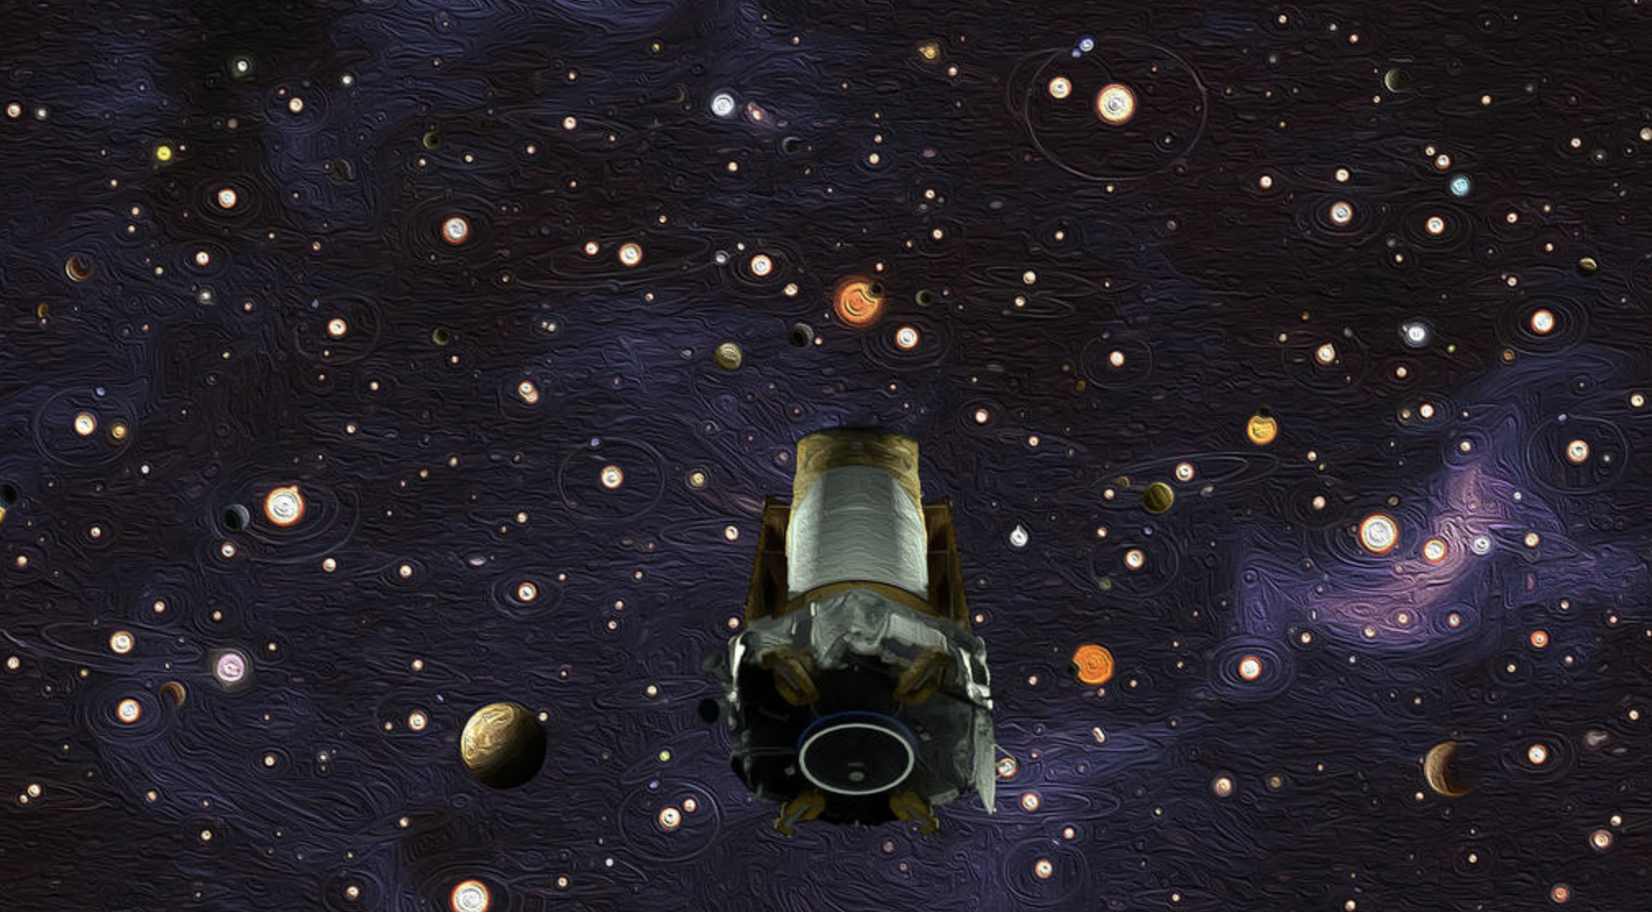

Gone are the days of manually observing and storing a handful of stars; modern astronomy is characterized by datasets of unprecedented size and complexity.  

Because it is unfeasible for human researchers to manually sift through datasets of this size, research methods have adapted: modern astronomers use statistical learning methods to find and quantify patterns in big astrophysical datasets.

In this tutorial, you will work through the techniques and concepts introduced in the lecture to analyze data from the _Kepler_ mission.
By the end of the tutorial, you will be ready to deploy a statistical learning algorithm to automatically distinguish different types of stars from patterns in how their brightness varies over time.
This repeated measurement of brightness over time is called a [_light curve_](https://imagine.gsfc.nasa.gov/science/toolbox/timing1.html).

The amazing _Kepler_ light curve time series that we will be analyzing today __takes a brightness measurement every 29.45 minutes__.

As we shall see in this tutorial, a sizeable part of any statistical learning effort is preprocessing the data.  We shall spend most of our time on this, hoping to see by the end a distinction between two star types that might be detectable by a machine learning algorithm.


## Background

Consider the problem of predicting the type of star from the properties of its light curve.

There are seven different classes of stars that we're interested in detecting (class labels are annotated in parentheses):

1. Detached binary (`'detached'`)
2. Contact binary (`'contact'`)
3. RR Lyrae variable (`'RRLyr'`)
4. Gamma Doradus variable (`'gDor'`)
5. Delta Scuti variable (`'dSct'`)
6. Rotating variable (`'rot'`)
7. Non-variable (`'nonvar'`)

Take a moment to inspect a representative example of each class in the time-domain and frequency-domain plots shown below.
How do periodic structures in the time domain manifest in the frequency domain?
Just looking at the data, what types of properties do you think are going to be useful in distinguishing these seven types of stars?

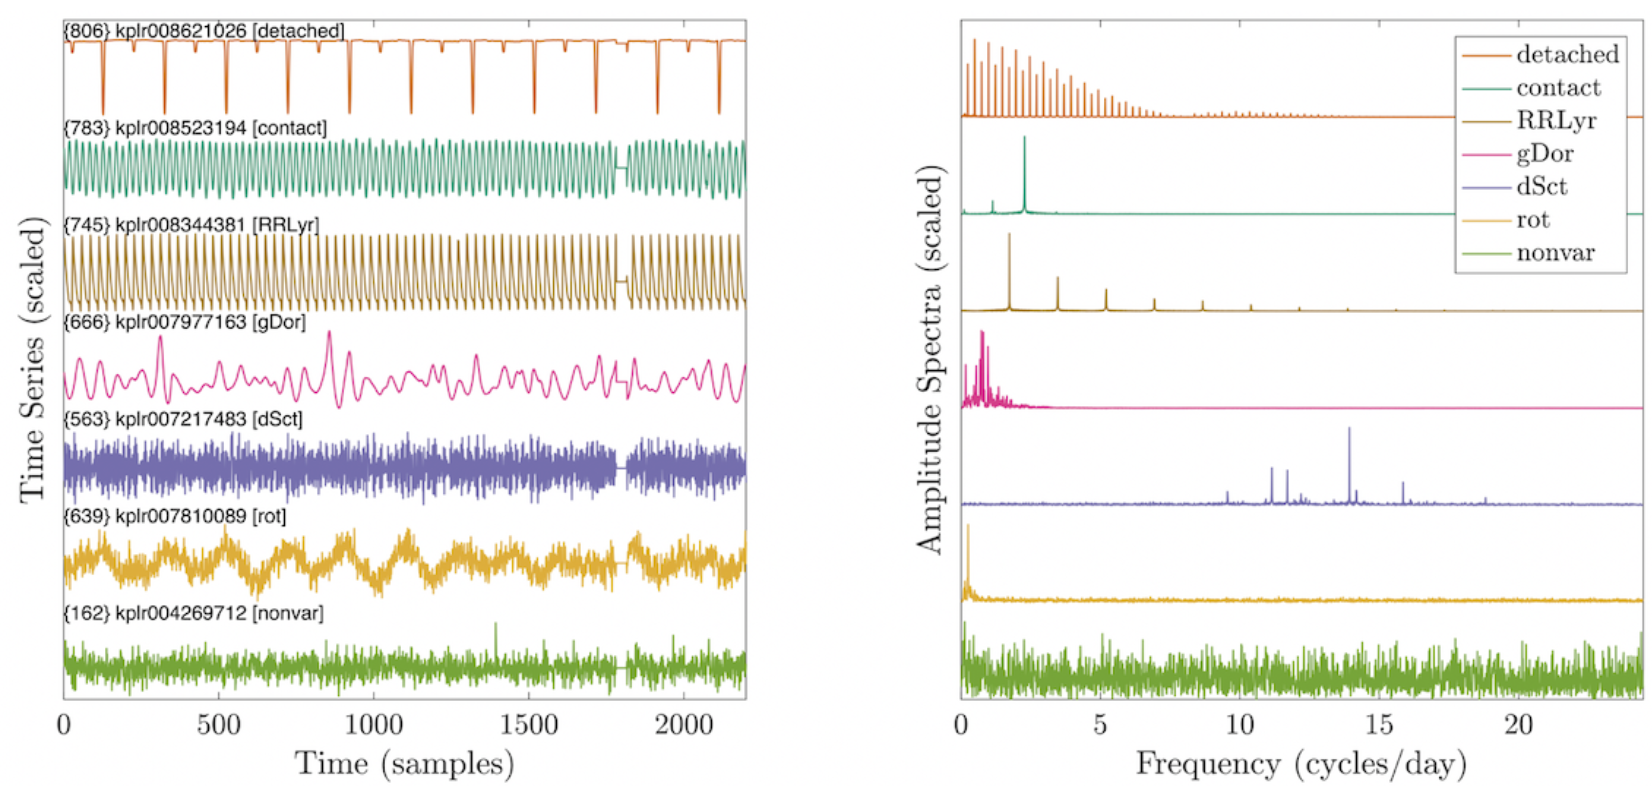


1. As there are labelled examples of stars and the task is to train an algorithm to map from input features to those known labels, it is a supervised problem.
2. This is a classification problem as it assigns each star to discrete categories rather than predicting a continuous value.

<div style="background-color:lightcyan;">
<span style="color:red"><center> <h1> Exercise 1 Submission</h1></center></span>
<p>Given the problem of predicting the type of star from the properties of its light curve:
    
1. Is it a supervised or unsupervised problem?

2. Is it a classification or regression problem?  

Submit your text answers to these questions.</p>
</div>

### Exploring the dataset

First we need to understand how our data is structured.  Download the file `Kepler_table.csv` from Canvas and read it in using the `pandas` command `read_csv`.  You can display the first few lines in the resulting dataframe using the dataframe method `.head()`.  Remember, a method associated with an object is accessed by using the object's name and then following by a dot and then the method name followed by round brackets (sometimes with data passed into the brackets).

Load in the data and try to understand how it is stored.

In [2]:
import pandas as pd

# Load the dataset (make sure the file is in your working directory, or provide the full path)
df = pd.read_csv("Kepler_table.csv")

# Display the first few rows
print(df.head())

# See the overall shape of the dataset (rows, columns)
print("Shape of dataset:", df.shape)

# List the column names
print("Columns:", df.columns)

# Get a quick summary of the dataset
print(df.info())

# View some summary statistics of the numeric columns
print(df.describe())


            Name Keywords  Length    Data_1    Data_2    Data_3    Data_4  \
0  kplr001026294     dSct    4767 -0.000529  0.000310  0.000280 -0.000580   
1  kplr001164109      rot    4767 -0.000173 -0.000090 -0.000139 -0.000237   
2  kplr001295531     gDor    4767  0.006339  0.005614  0.004688  0.003903   
3  kplr001434660     dSct    4767 -0.000532  0.001226  0.001134 -0.000250   
4  kplr001435836      rot    4767  0.000381  0.000253  0.000457  0.000169   

     Data_5    Data_6    Data_7  ...  Data_4760  Data_4761  Data_4762  \
0 -0.000579 -0.000579 -0.000579  ...   0.000619   0.000619   0.000668   
1 -0.000164 -0.000234 -0.000269  ...  -0.000296  -0.000216  -0.000263   
2  0.002912  0.001975  0.001009  ...  -0.002416  -0.002867  -0.003460   
3 -0.000326  0.000411  0.000509  ...   0.001185   0.001614  -0.000020   
4  0.000313  0.000155  0.000174  ...  -0.000147  -0.000270  -0.000213   

   Data_4763  Data_4764  Data_4765  Data_4766  Data_4767  ID  Group  
0   0.000039   0.000314   0.

#### Aggregating data

You will notice in the data that there are many columns called `Data`.  These correspond to light measurements of a star and are arranged in order of increasing time.  They are not currently in a form which allows for a plot of the light curve of a star.  Our first data wrangling step is to work out how to turn a series of columns into an array, which can then be plotted.

Pandas dataframe objects have many useful methods which we can call upon.  To address particular locations in a dataframe we can use `.iloc()`.  You can pass into this method row and column details and this will return a 'mini' version of the dataframe containing only the data you have selected out.  We can then use another dataframe method: `.to_numpy` to convert a series of columns into a numpy array.  Implement this for the first row in the dataframe and plot the resulting array.

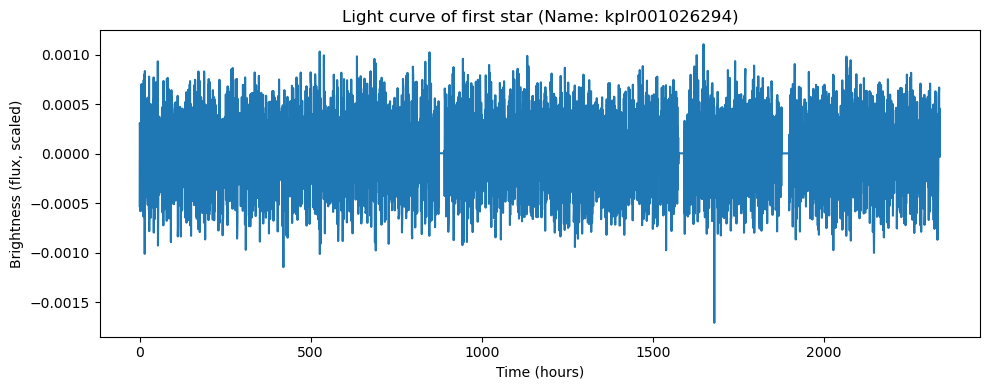

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Kepler_table.csv")

# Select only the light-curve columns (Data_1 ... Data_4767)
data_cols = df.filter(regex=r"^Data_\d+$").columns

# --- First star's light curve as a numpy array ---
light_curve = df.loc[0, data_cols].to_numpy(dtype=float)

# (Optional) build a time axis using Kepler's 29.45 min cadence
dt_minutes = 29.45
t_hours = np.arange(light_curve.size) * (dt_minutes / 60.0)  # or /24 for days

# Plot
plt.figure(figsize=(10, 4))
plt.plot(t_hours, light_curve)
plt.xlabel("Time (hours)")  # or "Time (samples)" if you prefer indices
plt.ylabel("Brightness (flux, scaled)")
plt.title(f"Light curve of first star (Name: {df.loc[0,'Name']})")
plt.tight_layout()
plt.show()


#### Time data

Let's now plot the light curve correctly against time.  We are told that a brightness measurement takes place every 29.45 minutes.  Set up a time array measured in units of days to plot your light curve data against. Create your plot below for the star contained in the first row of the dataframe.

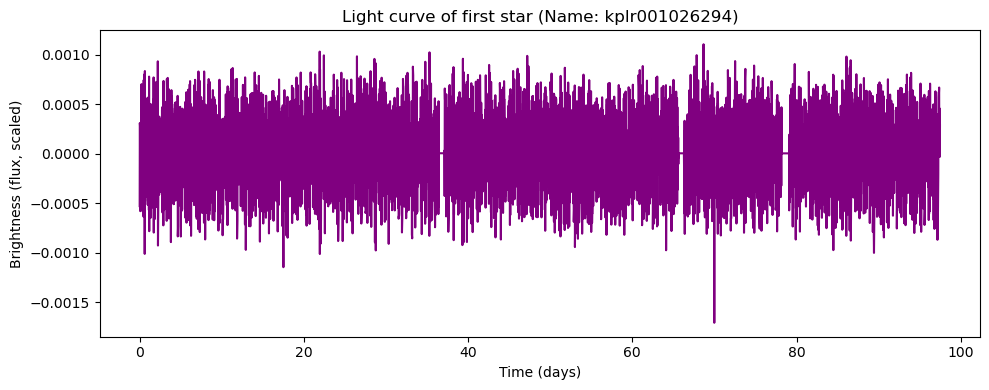

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Select only the light-curve columns
data_cols = df.filter(regex=r"^Data_\d+$").columns

# Light curve for the first star
light_curve = df.loc[0, data_cols].to_numpy(dtype=float)

# --- Time array in days ---
dt_days = 29.45 / (60 * 24)  # 29.45 minutes expressed in days
time_days = np.arange(light_curve.size) * dt_days

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(time_days, light_curve, color="purple")
plt.xlabel("Time (days)")
plt.ylabel("Brightness (flux, scaled)")
plt.title(f"Light curve of first star (Name: {df.loc[0,'Name']})")
plt.tight_layout()
plt.show()


#### Plot a light curve

We are now ready to approach the data more systematically.  To do this we will set up a function which allows us to extract the timeseries data for a particular row of a the dataframe.  Your function should take in a dataframe and a row number and return a numpy array holding the timeseries data.

Using your function create a plot of the time series at the row number 101 in units of days (note this is Python numbering, so it is the 102nd row in the dataframe).  Include in the title the name and keyword of the associated star.

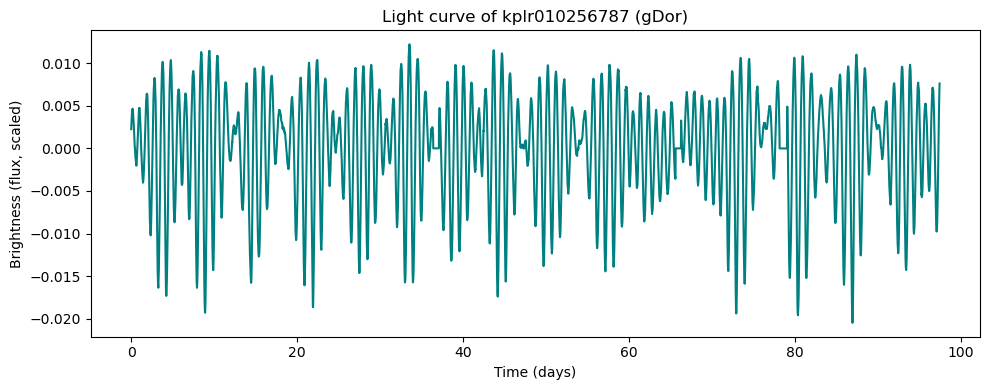

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Function to extract timeseries data from a given row
def get_light_curve(df, row):
    """
    Extracts the light curve timeseries for a star at a given row index.
    
    Parameters:
        df (pd.DataFrame): The Kepler dataframe
        row (int): Row index (0-based)
    
    Returns:
        np.ndarray: Light curve flux values as a numpy array
    """
    data_cols = df.filter(regex=r"^Data_\d+$").columns
    return df.loc[row, data_cols].to_numpy(dtype=float)

# --- Example: star in row 101 (the 102nd row) ---
row_num = 101
light_curve = get_light_curve(df, row_num)

# Build matching time array (in days)
dt_days = 29.45 / (60 * 24)  # 29.45 minutes → days
time_days = np.arange(light_curve.size) * dt_days

# Grab star info for the title
star_name = df.loc[row_num, "Name"]
star_keyword = df.loc[row_num, "Keywords"]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(time_days, light_curve, color="teal")
plt.xlabel("Time (days)")
plt.ylabel("Brightness (flux, scaled)")
plt.title(f"Light curve of {star_name} ({star_keyword})")
plt.tight_layout()
plt.show()


<div style="background-color:lightcyan;">
<span style="color:red"><center> <h1> Exercise 2 Submission</h1></center></span>
<p>Submit the timeseries plot you created for the star in row 101 in the previous exercise, including the name and keyword type in the title, and plotting against time in units of days.</p>
</div>

### _Context_: Feature extraction

Recall from lectures that supervised learning problems can be represented in the form of:

1. An observation x feature data matrix (`X`), and
2. A target output vector (`y`).

In this tutorial we are going to represent time series by their different properties in the matrix `X`, and label each by one of seven categories of stars in `y`.

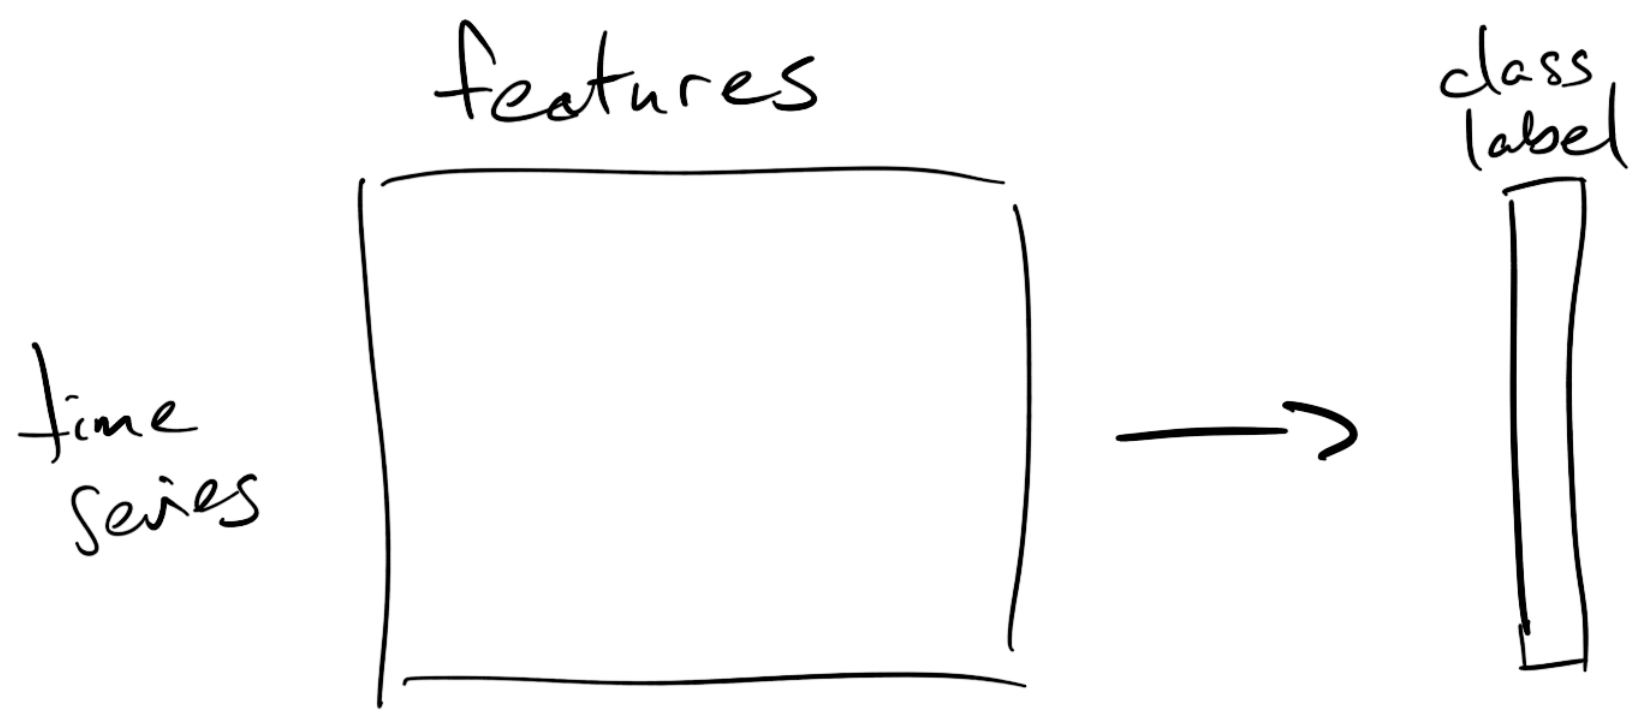


### Two-Class Classification

Seven classes is a bit daunting to start with, so let's instead approach a simpler version of this problem by considering only two classes of star.

#### Filtering to a subset

We now have some more wrangling to perform.  We would like to extract from our full dataframe only the data associated with a particular star.  We can use another nice pandas method `isin` (i.e. 'is in') to carry out the filtering that we need.  Let's focus on the classes `contact` and `nonvar`.  Create two filtered dataframes `df_contact` and `df_nonvar` which hold the data of the `contact` and `nonvar` classes respectively.  To achieve this you will do something like `df[df[indicator column].isin(indicator of interest]`.


In [13]:
# Contact stars (Group = 2)
df_contact = df[df["Group"] == 2]

# Non-variable stars (Group = 7)
df_nonvar = df[df["Group"] == 7]

print("Contact stars:", df_contact.shape)
print("Non-variable stars:", df_nonvar.shape)



Contact stars: (91, 4772)
Non-variable stars: (25, 4772)


#### Plotting in the frequency domain

Periodicities are ubiquitous in nature, and a common first step as a physicist is to transform a time series to the frequency domain.

When we compute the Fourier transform of a signal we obtain a result with both positive and negative frequencies.  This is a consequence of the mathematical representation used to represent plane wave solutions, and corresponds to a 'sense of rotation' (see e.g. https://en.wikipedia.org/wiki/Negative_frequency).  We are interested in the amount of power contained in particular frequencies for our real-valued time series, so we should compute the real FFT and then double the result (except at frequency 0), to account for the power contained in the negative frequencies.  

We can sidestep the details by using an inbuilt implementation of 'Welch's method' (https://en.wikipedia.org/wiki/Welch%27s_method).  This is called by first importing `welch` from `scipy.signal`.  A call to `welch` then looks like `welch(signal_data,fs = frequency_of_sampling,nperseg=1024)` where `nperseg` indicates the length of each segment in the algorithm (for which 1024 should work fine).




We first need to identify the frequencies that are accessible to us given our sampling period and length of sampling.  Given our sample period, what is our frequency of sampling in Hz?

0.000566 Hz

The `welch` routine will return both the frequencies at which the signal is sampled and the power spectrum at these frequencies.  Call `welch` and plot the output here.

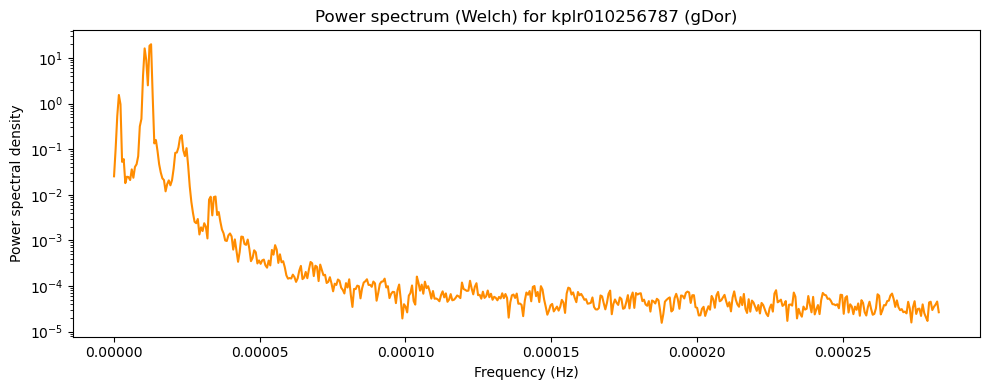

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# --- Extract the light curve for one star (say row 101 again) ---
data_cols = df.filter(regex=r"^Data_\d+$").columns
light_curve = df.loc[101, data_cols].to_numpy(dtype=float)

# --- Sampling frequency in Hz ---
Ts = 29.45 * 60            # sampling period in seconds (29.45 min → sec)
fs = 1 / Ts                # sampling frequency (Hz)

# --- Welch's method ---
freqs, power = welch(light_curve, fs=fs, nperseg=1024)

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, power, color="darkorange")   # semilogy = log scale for power
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density")
plt.title(f"Power spectrum (Welch) for {df.loc[101,'Name']} ({df.loc[101,'Keywords']})")
plt.tight_layout()
plt.show()


To make it easier to compare different signals, let's plot on a dB scale.  To do this take the log (base 10) of your power spectral density (the output from `welch`) and multiply this by 10.  Plot the resulting power spectrum versus frequency.

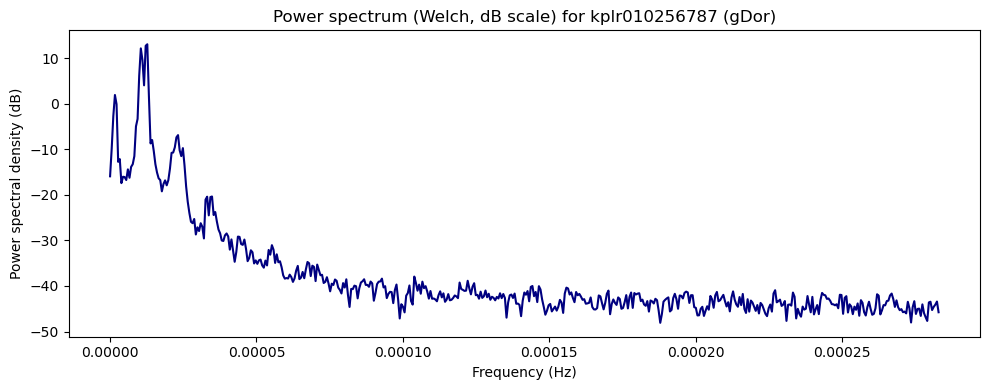

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# --- Extract the light curve for one star (row 101 again) ---
data_cols = df.filter(regex=r"^Data_\d+$").columns
light_curve = df.loc[101, data_cols].to_numpy(dtype=float)

# --- Sampling frequency in Hz ---
Ts = 29.45 * 60   # 29.45 minutes → seconds
fs = 1 / Ts       # sampling frequency

# --- Welch's method ---
freqs, power = welch(light_curve, fs=fs, nperseg=1024)

# --- Convert power spectrum to dB scale ---
power_dB = 10 * np.log10(power)

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(freqs, power_dB, color="navy")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density (dB)")
plt.title(f"Power spectrum (Welch, dB scale) for {df.loc[101,'Name']} ({df.loc[101,'Keywords']})")
plt.tight_layout()
plt.show()


We have one more post-processing step to perform.  The maximum of the signal may vary, depending on the signal, but we would like to plot on a similar set of axes.  To do so, let's shift the power spectrum such that the maximum is zero.  Plot this shifted power spectral density versus frequency for the 0th element of the contact dataset.

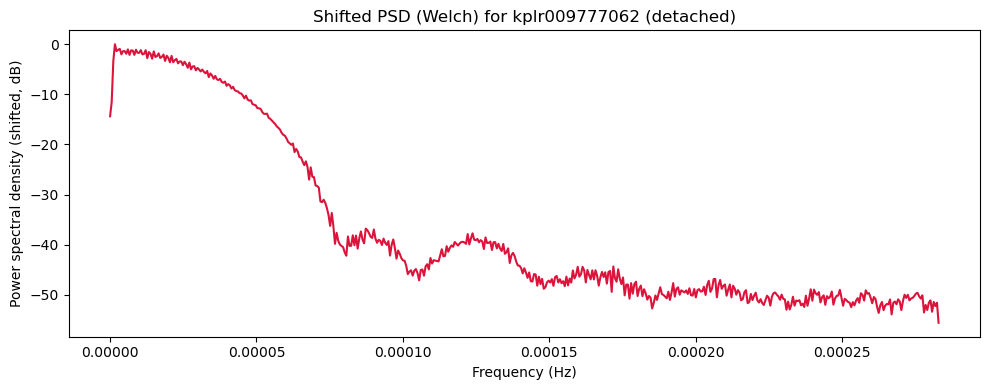

In [15]:


# --- Extract light curve for the first contact star ---
data_cols = df.filter(regex=r"^Data_\d+$").columns
light_curve = df_contact.iloc[0][data_cols].to_numpy(dtype=float)

# --- Sampling frequency (Hz) ---
Ts = 29.45 * 60   # 29.45 minutes → seconds
fs = 1 / Ts

# --- Welch's method ---
freqs, power = welch(light_curve, fs=fs, nperseg=1024)

# --- Convert to dB and shift so max is 0 ---
power_dB = 10 * np.log10(power)
power_dB_shifted = power_dB - np.max(power_dB)

# --- Grab star info for title ---
star_name = df_contact.iloc[0]["Name"]
star_keyword = df_contact.iloc[0]["Keywords"]

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(freqs, power_dB_shifted, color="crimson")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density (shifted, dB)")
plt.title(f"Shifted PSD (Welch) for {star_name} ({star_keyword})")
plt.tight_layout()
plt.show()


<div style="background-color:lightcyan;">
<span style="color:red"><center> <h1> Exercise 3 Submission</h1></center></span>
<p>Submit the power spectrum plot that you created for the 0th element of the contact dataset, plotted on a dB scale and shifted with maximum shifted to 0 dB.</p>
</div>

### Exploring the data

Remember what our goal is?
It's to compute two numbers ('features') that can capture useful differences between `'contact'` and `'nonvar'` stars.

To prepare for this, have a look at the timeseries and power spectrum plots for these two types of stars.  Are there any features that look like good candidates to distinguish between the two types of star?
 

### Choose your own features

After exploring, you will need to complete the function, `f = MyTwoFeatures(x);` that takes in a time-series, `x`, and outputs two features (real numbers stored in the two-element vector, `f`), that represent two different properties of the power spectrum.

You need to set this function up to implement the calculation of two features, as described below.
 

#### Normalising

Before we look for features, let's first normalise the timeseries, so our output is not affected by how bright the star is.  To do this we need to compute the zscore, as we did in an earlier lab.  This can be done simply by importing `zscore` from `scipy.stats`.  This normalisation step will be inlcuded in your `MyTwoFeatures` function.  Check that it works here.

#### _Feature 1_: Peak in the power spectrum

Perhaps you noticed that the contact binaries have characteristic oscillations.
Let's first measure how 'peaky' the power spectrum is.
The simplest metric for quantifying this is to simply take the `max` of the power spectral density (without any of the scaling or shifting steps we performed above).

**Optional Challenge**
Feel free to instead implement an alternative feature, like the `skewness`, or an explicit peak-finding function ---anything that implements this idea of generating a _single real number_ that captures the peakiness of the power spectrum.

In [16]:
import numpy as np
from scipy.signal import welch

def MyTwoFeatures(x, fs, nperseg=1024):
    """
    x  : 1D time series (numpy array)
    fs : sampling frequency in Hz
    returns: np.array([feature1, feature2])
    """
    # Welch PSD
    freqs, psd = welch(x, fs=fs, nperseg=min(nperseg, len(x)))
    
    # Guard against zeros/NaNs
    psd = np.asarray(psd, dtype=float)
    psd[~np.isfinite(psd)] = 0.0
    psd[psd <= 0] = np.finfo(float).tiny

    # Feature 1: Peak-to-median in dB (peakiness)
    psd_db = 10.0 * np.log10(psd)
    f1 = psd_db.max() - np.median(psd_db)

    # Feature 2: Spectral entropy (spread)
    p = psd / psd.sum()
    f2 = -(p * np.log(p)).sum() / np.log(len(p))

    return np.array([f1, f2])


#### _Feature 2_: Power in a frequency band

Oscillatory structure may also be concentrated in a particular frequency range.
Looking again at the frequency spectra you plotted above, pick a frequency range that you think is going to be informative of the differences between contact binaries and non-variable stars.  As we have already computed the power spectral density with `welch` all we need to do is integrate across this band.  To do this, we can establish a range of frequencies that we wish to consider, and the associated spectral power densities, and pass these two arrays into the `np.trapz` function to perform the integration.

Implement this as your second feature in `MyTwoFeatures`.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Columns holding the time series
data_cols = df.filter(regex=r"^Data_\d+$").columns

# Sampling frequency (Hz): 29.45 min per sample
Ts = 29.45 * 60.0         # seconds
fs = 1.0 / Ts

# Two-class subset
df_contact = df[df["Group"] == 2].copy()   # contact
df_nonvar  = df[df["Group"] == 7].copy()   # non-variable

# Helper to extract a row's light curve
def row_series(s):
    return s[data_cols].to_numpy(dtype=float)

# Compute features
F_contact = np.vstack([MyTwoFeatures(row_series(s), fs) for _, s in df_contact.iterrows()])
F_nonvar  = np.vstack([MyTwoFeatures(row_series(s), fs) for _, s in df_nonvar.iterrows()])

# (Optional) keep names for debugging/labels
names_contact = df_contact["Name"].to_list()
names_nonvar  = df_nonvar["Name"].to_list()


#### Feature space

Now loop over all time series in for your two classes of star, computing your two features for each and storing the output for each in an appropriate array.

Have a brief celebration!
You have just develeoped the main algorithmic machinery to convert light curves into an interpretable two-dimensional feature space that will enable the automatic classification of Kepler stars!

#### Visualise!

Create a scatter plot of your features for your two different stars, with the star type colour coded.  Include a legend and label your axes.  

How well do your two features separate the two classes?

Given your understanding of what your features are measuring, can you interpret why the two classes are where they are in the feature space?

Are there any outliers?

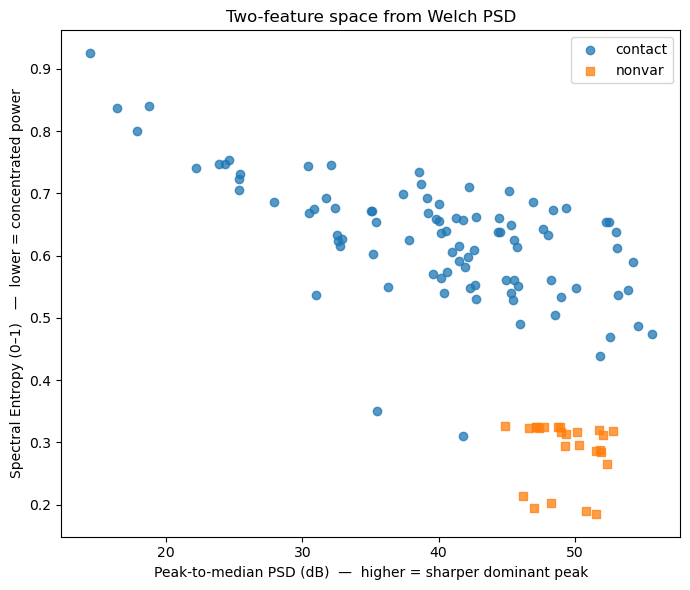

In [18]:
plt.figure(figsize=(7,6))

plt.scatter(F_contact[:,0], F_contact[:,1], alpha=0.75, label="contact", marker="o")
plt.scatter(F_nonvar[:,0],  F_nonvar[:,1],  alpha=0.75, label="nonvar",  marker="s")

plt.xlabel("Peak-to-median PSD (dB)  —  higher = sharper dominant peak")
plt.ylabel("Spectral Entropy (0–1)   —  lower = concentrated power")
plt.title("Two-feature space from Welch PSD")
plt.legend()
plt.tight_layout()
plt.show()


<div style="background-color:lightcyan;">
<span style="color:red"><center> <h1> Exercise 4 Submission</h1></center></span>
<p>Submit the scatter plot you created of your two features for the two classes of stars.</p>
</div>

#### Building a statistical model

You have done all this work creating a feature set.  Now you can train a classifier.  As we saw in lectures there are numerous possibilities, and we didn't go into any of the details.  Let's use a support vector machine (SVM) classifier, which in simple terms can be thought of as a souped-up variant of the single-neuron classifier we studied earlier.

To proceed with this we need to first train the model, by passing in a single matrix containing the two feature results for both types of star, along with another vector containing the associated labels (identifying the associated class for each star in the feature matrix).  

We can then simply use the `svm` model from the `sklearn` library and split our data into training and test sets using `train_test_split` from `sklearn.model_selection`.  The code steps are then only a few lines, looking something like:

`X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)`

`clf = svm.SVC(kernel='linear', C=1.0)  # linear SVM`

`clf.fit(X_train, y_train)`

where `X` is the feature matrix and `Y` is the label vector.


#### Data preparation

Set up two numpy arrays `X` and `Y`, with `X` holding all the two feature data for the stars you are looking at ('contact' and 'nonvar').  So it should be an array in which each row corresponds to a star, and the columns hold the feature values.  `Y` instead is a 1D vector holding a label which indicates which class the star belongs to.  Note: a binary label should be sufficient here, we just need a label that distinguishes between the two.  Set up your two vectors here

In [19]:
# Stack feature arrays vertically: (N_contact + N_nonvar, 2)
X = np.vstack([F_contact, F_nonvar])
# Create labels: 1 for contact, 0 for nonvar (binary classification)
y_contact = np.ones(F_contact.shape[0], dtype=int)
y_nonvar  = np.zeros(F_nonvar.shape[0], dtype=int)

# Concatenate into a single vector
Y = np.concatenate([y_contact, y_nonvar])

print("X shape:", X.shape)   # should be (116, 2) given 91+25 stars
print("Y shape:", Y.shape)   # should be (116,)
print("Class balance:", np.bincount(Y))


X shape: (116, 2)
Y shape: (116,)
Class balance: [25 91]


#### More data preprocessing

In practice there is often additional data preprocessing that needs to be done.  SVM will raise an error if there are any `NaN` entries in our data.  Check over your data, is this the case?  If so, we need to remove the lines corresponding to these NaN entries (in both the X and Y arrays).  To do so we can use a mask.  Here's a minimal implementation:

`mask = ~np.isnan(X).any(axis=1)`

`X_clean = X[mask]`

`Y_clean = Y[mask]`

#### Model building!

We're now ready to build the statistical model.  Using the code guidelines above, set up the statistical model for your data, splitting your data into training and test sets.  The default given above should be fine.

#### Model testing

Now let's see how the model performs on unseen data.  This is as simple as passing in your test data into the `predict` method of your object, i.e. something like `clf.predict(test data here)`.  This should give back predictions of the labels expected given the features that you have passed into the model.  Print out your predictions and compare with the test data labels.  How has your model performed?
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(Y_test, y_pred))

#### Testing metrics

In practice we want a quantitative measure of performance.  In the lecture we saw two possibilities: accuracy and a confusion matrix.  Let's implement these two.  Again `sklearn` makes it easy for us.  We can important the appropriate metrics in the following way:

`from sklearn.metrics import accuracy_score, confusion_matrix`

To compute these metrics we pass in the predicted labels, and the actual labels, and we will obtain a score as output.

And there we have it, a fully functioning statistical learning pipeline!  To go further we could return to our original dataset and carry out this process for all seven classes.

In [21]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- 1) Remove any rows that contain NaNs in X (and the matching labels in Y) ---
mask = ~np.isnan(X).any(axis=1)
X_clean = X[mask]
Y_clean = Y[mask]

print("Kept rows:", X_clean.shape[0], "Dropped rows:", (~mask).sum())

# --- 2) Train/test split (stratify keeps class balance in both splits) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, Y_clean, test_size=0.2, random_state=0, stratify=Y_clean
)

# --- 3) Build model: Standardize features + Linear SVM ---
clf = make_pipeline(
    StandardScaler(),                # SVM benefits from scaling
    svm.SVC(kernel='linear', C=1.0)  # linear SVM as per instructions
)

# --- 4) Train ---
clf.fit(X_train, y_train)

# --- 5) Test ---
y_pred = clf.predict(X_test)

# --- 6) Metrics ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nDetailed report:\n", classification_report(y_test, y_pred, digits=3))


Kept rows: 116 Dropped rows: 0
Accuracy: 0.9583333333333334
Confusion matrix:
 [[ 5  0]
 [ 1 18]]

Detailed report:
               precision    recall  f1-score   support

           0      0.833     1.000     0.909         5
           1      1.000     0.947     0.973        19

    accuracy                          0.958        24
   macro avg      0.917     0.974     0.941        24
weighted avg      0.965     0.958     0.960        24



<div style="background-color:lightcyan;">
<span style="color:red"><center> <h1> Exercise 5 Submission</h1></center></span>
<p>Submit the accuracy and confusion matrix results for your SVM method</p>
</div>